In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np

from fastdtw import fastdtw

import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

import matplotlib.pyplot as plt

import rasterio
from osgeo import gdal, ogr, osr
from gdalconst import *
gdal.UseExceptions()

import datetime as dt

import stac

import time

## --

In [43]:
df_pontos = gpd.read_file('./DADOS/amostras_final_23n.geojson')
df_pontos.set_index('ponto_id', inplace=True)
df_pontos

,FONTE,dist_1,pivo_id,name,geometry
ponto_id,,,,,
776,ANA,73,156,23KKA,POINT (251722.462 -1900624.717)
777,ANA,73,156,23KKA,POINT (251193.640 -1900526.283)
778,ANA,73,156,23KKA,POINT (251292.782 -1900001.864)
779,ANA,73,156,23KKA,POINT (251821.603 -1900100.300)
780,ANA,73,156,23KKA,POINT (251722.462 -1900624.717)
...,...,...,...,...,...
11613,ANA,30,150,23KLB,POINT (310492.905 -1896291.022)
11614,ANA,30,150,23KLB,POINT (310338.600 -1896201.650)
11615,ANA,30,150,23KLB,POINT (310428.355 -1896048.862)


In [44]:
# Abrir arquivo resultados
df = -pd.read_pickle('./DADOS/df_classif_final_euclidian.pkl')
df.index.rename('ponto_id', inplace=True)
df

,2016,2017,2018,2019
ponto_id,,,,
1,False,False,False,False
2,False,False,False,False
3,False,False,False,False
4,False,False,False,False
6,False,False,False,False
...,...,...,...,...
11907,False,False,False,False
11909,False,False,False,False
11910,False,False,False,False


## Cortar séries pelos anos agricolas

In [45]:
df_result = df.join(df_pontos, on='ponto_id').sort_index()
df_result

,2016,2017,2018,2019,FONTE,dist_1,pivo_id,name,geometry
ponto_id,,,,,,,,,
1,False,False,False,False,ANA,49,1,23KKB,POINT (277206.034 -1843558.198)
2,False,False,False,False,ANA,49,1,23KKB,POINT (277469.523 -1843231.580)
3,False,False,False,False,ANA,49,1,23KKB,POINT (277798.519 -1843493.188)
4,False,False,False,False,ANA,49,1,23KKB,POINT (277535.031 -1843819.806)
6,False,False,False,False,ANA,62,2,23KKB,POINT (279047.682 -1844911.617)
...,...,...,...,...,...,...,...,...,...
11907,False,False,False,False,ANA,31,205,23KLA,POINT (332344.296 -1921394.667)
11909,False,False,False,False,ANA,97,204,23KLA,POINT (330239.192 -1919653.748)
11910,False,False,False,False,ANA,97,204,23KLA,POINT (330041.887 -1919525.584)


In [46]:
soma_todos = df_result.drop(['dist_1','FONTE','name','geometry'],axis=1).groupby('pivo_id').count()

soma_falsos = df_result.drop(['dist_1'],axis=1).groupby('pivo_id').sum()
soma_falsos.loc[soma_falsos.any(axis=1) , : ]

,2016,2017,2018,2019
pivo_id,,,,
62,0.0,0.0,1.0,0.0
99,0.0,0.0,0.0,4.0
106,0.0,1.0,0.0,0.0
123,0.0,1.0,0.0,0.0
129,2.0,0.0,0.0,0.0
...,...,...,...,...
1168,0.0,0.0,3.0,0.0
1169,0.0,0.0,1.0,0.0
1173,6.0,1.0,0.0,0.0


In [47]:
percent = round((soma_falsos/soma_todos)*100,2)
percent.replace({12.5:0 , 8.33:0, 16.67:0, 14.29:0, 37.50:25, 62.5:50}, inplace=True)
percent = percent.loc[percent.any(axis=1) , : ]
percent

,2016,2017,2018,2019
pivo_id,,,,
99,0.0,0.0,0.0,50.0
129,25.0,0.0,0.0,0.0
136,0.0,0.0,0.0,25.0
246,0.0,0.0,0.0,25.0
290,25.0,0.0,0.0,0.0
351,0.0,0.0,0.0,50.0
385,0.0,25.0,0.0,0.0
388,50.0,0.0,0.0,0.0
416,50.0,0.0,0.0,0.0


In [144]:
label = [str((len([x for x in percent[i] if x == z ])/1186)*100) for z in (25, 50, 75, 100)]

[0.6745362563237773, 0.25295109612141653, 0.08431703204047217, 0.0]

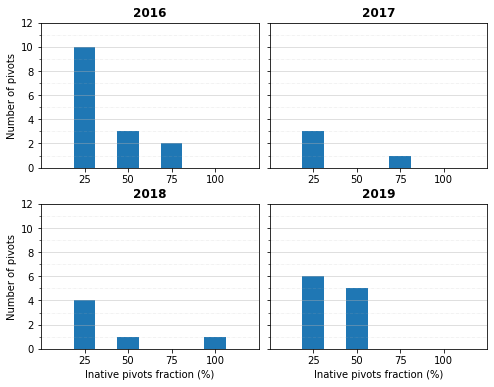

In [105]:
fig , ax = plt.subplots(2,int(percent.shape[1]/2), figsize=(8,6), sharey=True )
fig.subplots_adjust(wspace = .05,hspace=.25)

for i, axes in zip(percent, ax.flat):
    axes.hist(percent[i], bins=(1, 25, 50, 75, 100, 125), align='left', rwidth=0.5)
    
    axes.set_xticks([25, 50, 75, 100])
    axes.set_yticks(range(15), minor=True)
    axes.set_ylim(0, 12)
    axes.set_xlim(0, 125)

    axes.grid(axis='y', ls='-.',lw=0.5, alpha=0.3, which='minor')
    axes.grid(axis='y', alpha=0.5, which='major')

    
    axes.set_title(i, weight='bold')
    
    if i == '2016' or i == '2018':
        axes.set_ylabel('Number of pivots')
        
    if i == '2018' or i == '2019':   
        axes.set_xlabel('Inative pivots fraction (%)')
    

    

In [32]:
from IPython.display import display

pd.options.display.max_rows = 1200
display(df_result.drop(['dist_1'],axis=1).groupby(['pivo_id']).sum())

,2016,2017,2018,2019
pivo_id,,,,
1,10.0,10.0,10.0,10.0
2,10.0,10.0,10.0,10.0
3,10.0,10.0,10.0,10.0
4,10.0,10.0,10.0,10.0
5,10.0,10.0,10.0,10.0
6,10.0,10.0,10.0,10.0
7,10.0,10.0,10.0,10.0
8,10.0,10.0,10.0,10.0
9,10.0,10.0,10.0,10.0


In [24]:
percent

,2016,2017,2018,2019
pivo_id,,,,
99,0.0,0.0,0.0,50.0
129,25.0,0.0,0.0,0.0
136,0.0,0.0,0.0,25.0
246,0.0,0.0,0.0,25.0
290,25.0,0.0,0.0,0.0
351,0.0,0.0,0.0,50.0
385,0.0,25.0,0.0,0.0
388,50.0,0.0,0.0,0.0
416,50.0,0.0,0.0,0.0


In [112]:
max(soma_todos.loc[soma_todos['2016']!=8,'2016'])

16